In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv('/content/E-com_Data.csv')

data.shape

(541116, 12)

In [6]:
data.head()

,CustomerID,Item Code,InvoieNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177.0,29-10-2017,6.0,3:36:00 PM,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422.0,05-10-2017,2.0,2:53:00 PM,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422.0,12-10-2017,2.0,2:53:00 PM,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633.0,22-08-2017,3.0,2:47:00 PM,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422.0,10-10-2017,2.0,2:53:00 PM,944.0,1888.0,Location 1,NaN,NaN,NaN


In [ ]:
# Columns used for RFM analysis grouped by CustomerID
    # 1. Recency - Date of purchase
    # 2. Frequency - InvoiceNo
    # 3. Monetory - Price

In [7]:
data = data[[	'CustomerID' , 'InvoieNo', 'Date of purchase', 'Price']]

data= data.rename(columns={'InvoieNo': 'InvoiceNo','Date of purchase' :'Date'})

data.head()

,CustomerID,InvoiceNo,Date,Price
0,4355.0,398177.0,29-10-2017,1926.0
1,4352.0,394422.0,05-10-2017,1740.0
2,4352.0,394422.0,12-10-2017,1866.0
3,4352.0,388633.0,22-08-2017,1869.0
4,4352.0,394422.0,10-10-2017,1888.0


In [8]:
round(data.isnull().mean()*100,2)

,0
CustomerID,25.30
InvoiceNo,0.58
Date,0.58
Price,0.58


In [10]:
data = data.dropna(subset=['CustomerID'])

round(data.isnull().mean()*100,2)

,0
CustomerID,0.0
InvoiceNo,0.0
Date,0.0
Price,0.0


In [11]:
print('Number of Duplicate rows in the data before treating:', data.duplicated().sum())
data = data.drop_duplicates(ignore_index=False)
print('Number of Duplicate rows in the data after treating:', data.duplicated().sum())

Number of Duplicate rows in the data before treating: 1330
Number of Duplicate rows in the data after treating: 0


In [12]:
data.dtypes

,0
CustomerID,float64
InvoiceNo,float64
Date,object
Price,float64


In [13]:
data['CustomerID'] = data['CustomerID'].astype(int)
data['InvoiceNo'] = data['InvoiceNo'].astype(int)
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

,0
CustomerID,int64
InvoiceNo,int64
Date,datetime64[ns]
Price,float64


In [14]:
data.head()

,CustomerID,InvoiceNo,Date,Price
0,4355,398177,2017-10-29,1926.0
1,4352,394422,2017-10-05,1740.0
2,4352,394422,2017-10-12,1866.0
3,4352,388633,2017-08-22,1869.0
4,4352,394422,2017-10-10,1888.0


In [15]:
data['Date'].max()

Timestamp('2017-12-19 00:00:00')

In [20]:
latest_date = dt.datetime(2017, 12, 20)
latest_date

datetime.datetime(2017, 12, 20, 0, 0)

In [21]:
data.head()

,CustomerID,InvoiceNo,Date,Price
0,4355,398177,2017-10-29,1926.0
1,4352,394422,2017-10-05,1740.0
2,4352,394422,2017-10-12,1866.0
3,4352,388633,2017-08-22,1869.0
4,4352,394422,2017-10-10,1888.0


In [24]:
##RFM

In [28]:
RFMScore = data.groupby('CustomerID').agg({'Date': lambda x: (latest_date-x.max()).days,
                                           'InvoiceNo': lambda x: x.count(),
                                           'Price': lambda x: x.sum()})
RFMScore.rename(columns={'Date': 'Recency', 'InvoiceNo':'Frequency', 'Price': 'Monetory'}, inplace = True)
RFMScore.reset_index().head()

,CustomerID,Recency,Frequency,Monetory
0,2,4,181,550416.0
1,3,77,27,257404.0
2,4,19,72,176613.0
3,5,311,16,41976.0
4,6,37,84,151822.0


In [30]:
for cols in RFMScore.columns:
  print(f'For {cols} the min value is {RFMScore[cols].min()} and max value is {RFMScore[cols].max()}')

For Recency the min value is 1 and max value is 381
For Frequency the min value is 1 and max value is 7919
For Monetory the min value is -50372.0 and max value is 35472089.0


In [31]:
quantile = RFMScore.quantile(q=[0.25,0.50,0.75])
quantile = quantile.to_dict()
quantile

{'Recency': {0.25: 18.0, 0.5: 51.0, 0.75: 144.0},
 'Frequency': {0.25: 17.0, 0.5: 42.0, 0.75: 101.0},
 'Monetory': {0.25: 38140.0, 0.5: 83635.0, 0.75: 205444.0}}

In [32]:
# lower the value of recency more valuable the customer is
def recency_score(x, q, d):
  if x<=d[q][0.25]:
    return 1
  elif x<=d[q][0.50]:
    return 2
  elif x<=d[q][0.75]:
    return 3
  else:
    return 4

# higher the value of frequency and monetory more valuable the customer is
def FnM_score(x, q, d):
  if x<=d[q][0.25]:
    return 4
  elif x<=d[q][0.50]:
    return 3
  elif x<=d[q][0.75]:
    return 2
  else:
    return 1

In [36]:
RFMScore['R_Score'] = RFMScore['Recency'].apply(recency_score, args=('Recency', quantile))
RFMScore['F_Score'] = RFMScore['Frequency'].apply(FnM_score, args=('Frequency', quantile))
RFMScore['M_Score'] = RFMScore['Monetory'].apply(FnM_score, args=('Monetory', quantile))

In [37]:
RFMScore.head()

,Recency,Frequency,Monetory,R_Score,F_Score,M_Score,LoyaltyScore
CustomerID,,,,,,,
2,4,181,550416.0,1,1,1,9
3,77,27,257404.0,3,3,1,9
4,19,72,176613.0,2,2,2,8
5,311,16,41976.0,4,4,3,7
6,37,84,151822.0,2,2,2,8


In [38]:
RFMScore['LoyaltyScore']=RFMScore[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
RFMScore.head()

,Recency,Frequency,Monetory,R_Score,F_Score,M_Score,LoyaltyScore
CustomerID,,,,,,,
2,4,181,550416.0,1,1,1,3
3,77,27,257404.0,3,3,1,7
4,19,72,176613.0,2,2,2,6
5,311,16,41976.0,4,4,3,11
6,37,84,151822.0,2,2,2,6


In [39]:
# Loyalty Badge
Badges = ['Platinum', 'Gold' , 'Silver', 'Bronze']
score_cut =pd.qcut(RFMScore.LoyaltyScore,4, labels=Badges)
RFMScore ['LoyaltyBadge'] = score_cut.values

RFMScore.head()

,Recency,Frequency,Monetory,R_Score,F_Score,M_Score,LoyaltyScore,LoyaltyBadge
CustomerID,,,,,,,,
2,4,181,550416.0,1,1,1,3,Platinum
3,77,27,257404.0,3,3,1,7,Gold
4,19,72,176613.0,2,2,2,6,Gold
5,311,16,41976.0,4,4,3,11,Bronze
6,37,84,151822.0,2,2,2,6,Gold


In [41]:
segmented_data = RFMScore.reset_index()
segmented_data = segmented_data[['CustomerID','Recency',	'Frequency','Monetory','LoyaltyBadge']]
segmented_data.head()

,CustomerID,Recency,Frequency,Monetory,LoyaltyBadge
0,2,4,181,550416.0,Platinum
1,3,77,27,257404.0,Gold
2,4,19,72,176613.0,Gold
3,5,311,16,41976.0,Bronze
4,6,37,84,151822.0,Gold


[Text(0, 0, '1313'), Text(0, 0, '1280'), Text(0, 0, '966'), Text(0, 0, '790')]

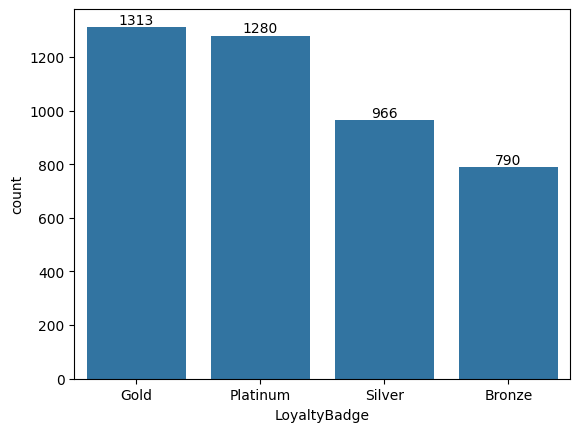

In [44]:
ax = sns.countplot(x=segmented_data['LoyaltyBadge'],
                   order=segmented_data['LoyaltyBadge'].value_counts().index)
ax.bar_label(ax.containers[0])
